In [1]:
!pip install nbformat
!pip install chardet

In [2]:
import pandas as pd
import os 
import requests 
import numpy as np 
import geopandas as gpd
import matplotlib.pyplot as plt 
import zipfile
import io
import re

### Download de la bdd parcelles bio 

In [3]:

# Dictionnaire des URLs par année
urls = {
    2022: 'https://www.data.gouv.fr/fr/datasets/r/36314eff-2712-4d6a-b091-7752a5b318bb',
    2021: 'https://www.data.gouv.fr/fr/datasets/r/e6cd3b9f-38e2-47ca-aac6-5acfb9567e01',
    2023: "https://www.data.gouv.fr/fr/datasets/r/e8639487-199c-4e30-8998-1b517148fe29",
}

for year, url_zip in urls.items():
    print(f"\nTraitement de l'année {year}...")

    # Chemin pour stocker temporairement le fichier téléchargé
    file_path = f"data_{year}.zip"

    # Télécharger le fichier
    response = requests.get(url_zip)
    if response.status_code != 200:
        print(f"Erreur lors du téléchargement pour l'année {year}: {response.status_code}")
        continue

    # Enregistrer le fichier localement
    with open(file_path, "wb") as f:
        f.write(response.content)

    # Vérifier si le fichier est un ZIP
    if zipfile.is_zipfile(file_path):
        print(f"Extraction du fichier ZIP pour l'année {year}")
        extract_path = f"data_extracted_{year}"
        if not os.path.exists(extract_path):
            os.makedirs(extract_path)
        with zipfile.ZipFile(file_path, "r") as zip_ref:
            zip_ref.extractall(extract_path)

        # Afficher tous les fichiers extraits pour diagnostic
        print(f"Fichiers extraits pour {year} :")
        extracted_files = []
        for root, _, files in os.walk(extract_path):
            for file in files:
                extracted_files.append(os.path.join(root, file))
                print(f"- {file}")

        # Lire les fichiers extraits si ce sont des CSV
        for file in extracted_files:
            if file.endswith(".csv"):
                gdf = pd.read_csv(file)
                globals()[f"gdf{year}"] = gdf.drop(columns='geometry', errors='ignore')
                print(f"Aperçu des données pour {year} :")
                print(globals()[f"gdf{year}"].head())
    else:
        print(f"Le fichier pour {year} n'est pas un ZIP.")



Traitement de l'année 2022...
Extraction du fichier ZIP pour l'année 2022
Fichiers extraits pour 2022 :
- rpg-bio-2022-national.gpkg
- ._rpg-bio-2022-national.gpkg

Traitement de l'année 2021...
Extraction du fichier ZIP pour l'année 2021
Fichiers extraits pour 2021 :
- rpg-bio-2021-national.gpkg

Traitement de l'année 2023...
Extraction du fichier ZIP pour l'année 2023
Fichiers extraits pour 2023 :
- rpg-bio-2023-national.shp
- rpg-bio-2023-national.cpg
- rpg-bio-2023-national.gpkg
- rpg-bio-2023-national.shx
- rpg-bio-2023-national.dbf
- rpg-bio-2023-national.prj


In [6]:
# Chemins vers les fichiers extraits
file_2022 = "data_extracted_2022/rpg-bio-2022-national.gpkg"
file_2021 = "data_extracted_2021/rpg-bio-2021-national.gpkg"
file_2023 = "/home/onyxia/work/AgricultureBio_France/data_extracted_2023/rpg-bio-2023-national/rpg-bio-2023-national.shp"  # Choix du .shp en raison d'un manque de data sur le .gpkg

# Charger les fichiers dans des variables distinctes
gdf2022 = gpd.read_file(file_2022)
gdf2021 = gpd.read_file(file_2021)
gdf2023 = gpd.read_file(file_2023)

# Supprimer la colonne 'geometry' pour chaque GeoDataFrame
gdf2022 = gdf2022.drop(columns=['geometry'])
gdf2021 = gdf2021.drop(columns=['geometry'])
gdf2023 = gdf2023.drop(columns=['geometry'])

# Afficher un aperçu des données après suppression de 'geometry'
print("Aperçu des données pour 2022 (sans geometry) :")
print(gdf2022.head())

print("\nAperçu des données pour 2021 (sans geometry) :")
print(gdf2021.head())

print("\nAperçu des données pour 2023 (sans geometry) :")
print(gdf2023.head())

/opt/conda/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: /home/onyxia/work/AgricultureBio_France/data_extracted_2023/rpg-bio-2023-national/rpg-bio-2023-national.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


Aperçu des données pour 2022 (sans geometry) :
       gid  millesime code_culture  \
0  4420687       2022          PPH   
1      333       2022          PTR   
2      337       2022          BTH   
3      464       2022          BTH   
4      480       2022          BTH   

                                         lbl_culture           grp_culture  \
0  Prairie permanente - herbe prédominante (resso...  Prairies permanentes   
1         Autre prairie temporaire de 5 ans ou moins  Prairies temporaires   
2                                 Blé tendre d’hiver            Blé tendre   
3                                 Blé tendre d’hiver            Blé tendre   
4                                 Blé tendre d’hiver            Blé tendre   

   surface_ha code_commune_insee             lbl_commune    code_epci  \
0        0.38              38513                Treffort  200030658.0   
1        2.13              01188                  Illiat  200070118.0   
2        6.10              01136  Cr

In [8]:
# Renommer les colonnes dans gdf2023
gdf2023.rename(columns={'code_regio': 'code_region', 'code_depar': 'code_departement'}, inplace=True)

# Vérifier les nouvelles colonnes
print("Colonnes après renommage dans gdf2023 :")
print(gdf2023.columns)


Colonnes après renommage dans gdf2023 :
Index(['gid', 'millesime', 'code_cultu', 'precision_', 'lbl_cultur',
       'grp_cultur', 'surface_ha', 'code_commu', 'lbl_commun', 'code_epci',
       'code_departement', 'code_region', 'zone_geo'],
      dtype='object')


In [10]:
# Récupérer les colonnes sous forme d'ensembles
columns_2022 = set(gdf2022.columns)
columns_2021 = set(gdf2021.columns)
columns_2023 = set(gdf2023.columns)

# Comparer les colonnes entre les trois jeux de données
common_columns = columns_2022 & columns_2021 & columns_2023  # Colonnes communes
unique_2022 = columns_2022 - (columns_2021 | columns_2023)  # Colonnes uniques à 2022
unique_2021 = columns_2021 - (columns_2022 | columns_2023)  # Colonnes uniques à 2021
unique_2023 = columns_2023 - (columns_2021 | columns_2022)  # Colonnes uniques à 2023

# Afficher les résultats
print("Colonnes communes aux trois GeoDataFrames :")
print(common_columns)

print("\nColonnes uniques à 2022 :")
print(unique_2022)

print("\nColonnes uniques à 2021 :")
print(unique_2021)

print("\nColonnes uniques à 2023 :")
print(unique_2023)


Colonnes communes aux trois GeoDataFrames :
{'code_epci', 'surface_ha', 'gid', 'zone_geo', 'millesime', 'code_departement', 'code_region'}

Colonnes uniques à 2022 :
set()

Colonnes uniques à 2021 :
set()

Colonnes uniques à 2023 :
{'grp_cultur', 'lbl_cultur', 'precision_', 'code_cultu', 'lbl_commun', 'code_commu'}


In [13]:
# Ajouter une colonne pour identifier l'année
gdf2021['annee'] = 2021
gdf2022['annee'] = 2022
gdf2023['annee'] = 2023

# Fusionner les trois GeoDataFrames en un seul DataFrame
df_combined = pd.concat([gdf2021, gdf2022, gdf2023], ignore_index=True)

# Vérifier les données fusionnées
print("Aperçu des données fusionnées :")
print(df_combined.head())


Aperçu des données fusionnées :
   surface_ha  gid     zone_geo code_departement  code_region  annee
0       10.19  261  France mét.               01         84.0   2021
1        1.53  263  France mét.               01         84.0   2021
2        7.01  267  France mét.               01         84.0   2021
3        1.37  268  France mét.               01         84.0   2021
4        0.59  274  France mét.               01         84.0   2021


### Traitement de la BDD pour achat de pesticide

In [15]:
# Colonnes restantes après exclusion de 'code_epci' et 'millesime'
features = ['code_departement', 'code_region', 'zone_geo', 'annee']

# Préparer X (caractéristiques) et y (cible)
X = df_combined[features]
y = df_combined['surface_ha']

# Vérifier les données après la sélection
print("Aperçu des caractéristiques (X) :")
print(X.head())
print("\nAperçu de la cible (y) :")
print(y.head())



Aperçu des caractéristiques (X) :
  code_departement  code_region     zone_geo  annee
0               01         84.0  France mét.   2021
1               01         84.0  France mét.   2021
2               01         84.0  France mét.   2021
3               01         84.0  France mét.   2021
4               01         84.0  France mét.   2021

Aperçu de la cible (y) :
0    10.19
1     1.53
2     7.01
3     1.37
4     0.59
Name: surface_ha, dtype: float64


In [52]:
# Liste des URLs des fichiers ZIP
urls_zip = {
    "2017": "https://data.ofb.fr/catalogue/Donnees-geographiques-OFB/api/records/a69c8e76-13e1-4f87-9f9d-1705468b7221/attachments/BNVD_TRACABILITE_20231024_ACHAT_2017.zip",
    "2018": "https://data.ofb.fr/catalogue/Donnees-geographiques-OFB/api/records/a69c8e76-13e1-4f87-9f9d-1705468b7221/attachments/BNVD_TRACABILITE_20231024_ACHAT_2018.zip",
    "2019": "https://data.ofb.fr/catalogue/Donnees-geographiques-OFB/api/records/a69c8e76-13e1-4f87-9f9d-1705468b7221/attachments/BNVD_TRACABILITE_20231024_ACHAT_2019.zip",
    "2020": "https://data.ofb.fr/catalogue/Donnees-geographiques-OFB/api/records/a69c8e76-13e1-4f87-9f9d-1705468b7221/attachments/BNVD_TRACABILITE_20231024_ACHAT_2020.zip",
    "2021": "https://data.ofb.fr/catalogue/Donnees-geographiques-OFB/api/records/a69c8e76-13e1-4f87-9f9d-1705468b7221/attachments/BNVD_TRACABILITE_20231024_ACHAT_2021.zip",
    "2022": "https://data.ofb.fr/catalogue/Donnees-geographiques-OFB/api/records/a69c8e76-13e1-4f87-9f9d-1705468b7221/attachments/BNVD_TRACABILITE_20231024_ACHAT_2022.zip"
}

# Dossier où seront stockés les fichiers CSV sélectionnés
output_dir = "dossier_Achats_pesticides_selected"
os.makedirs(output_dir, exist_ok=True)

# Modèle de nom de fichier cible (expression régulière)
file_pattern = r"BNVD_TRACABILITE_\d+_ACHAT_DPT_SUBSTANCE_(\d{4})\.csv"

# Boucle pour traiter chaque fichier ZIP
for year, url in urls_zip.items():
    print(f"--- Année {year} : Récupération des données depuis {url} ---")
    try:
        # Télécharger le fichier ZIP en mémoire
        response = requests.get(url)
        response.raise_for_status()
        
        # Ouvrir le fichier ZIP en mémoire
        with zipfile.ZipFile(io.BytesIO(response.content)) as z:
            # Filtrer pour sélectionner uniquement le fichier correspondant au modèle
            csv_files = [name for name in z.namelist() if re.search(file_pattern, name)]
            if csv_files:
                target_file = csv_files[0]  # Sélectionner le fichier correspondant
                print(f"Fichier CSV sélectionné pour {year} : {target_file}")
                
                # Construire le chemin pour sauvegarder le fichier dans le répertoire final
                output_path = os.path.join(output_dir, f"achats_pesticides_{year}.csv")
                
                # Extraire et sauvegarder le fichier CSV directement
                with z.open(target_file) as f:
                    df = pd.read_csv(f, sep=";", encoding="utf-8", on_bad_lines="skip")
                    df.to_csv(output_path, index=False, sep=";")
                    print(f"Fichier pour {year} sauvegardé : {output_path}")
            else:
                print(f"Aucun fichier correspondant trouvé dans l'archive ZIP pour {year}")
    except Exception as e:
        print(f"Erreur pour l'année {year} : {e}")

print("\n--- Traitement terminé. Tous les fichiers CSV sont dans le dossier : dossier_Achats_pesticides_selected ---")


--- Année 2017 : Récupération des données depuis https://data.ofb.fr/catalogue/Donnees-geographiques-OFB/api/records/a69c8e76-13e1-4f87-9f9d-1705468b7221/attachments/BNVD_TRACABILITE_20231024_ACHAT_2017.zip ---
Fichier CSV sélectionné pour 2017 : BNVD_TRACABILITE_20231023_ACHAT_DPT_SUBSTANCE_2017.csv


/tmp/ipykernel_7892/1820709967.py:39: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f, sep=";", encoding="utf-8", on_bad_lines="skip")


Fichier pour 2017 sauvegardé : dossier_Achats_pesticides_selected/achats_pesticides_2017.csv
--- Année 2018 : Récupération des données depuis https://data.ofb.fr/catalogue/Donnees-geographiques-OFB/api/records/a69c8e76-13e1-4f87-9f9d-1705468b7221/attachments/BNVD_TRACABILITE_20231024_ACHAT_2018.zip ---
Fichier CSV sélectionné pour 2018 : BNVD_TRACABILITE_20231023_ACHAT_DPT_SUBSTANCE_2018.csv


/tmp/ipykernel_7892/1820709967.py:39: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f, sep=";", encoding="utf-8", on_bad_lines="skip")


Fichier pour 2018 sauvegardé : dossier_Achats_pesticides_selected/achats_pesticides_2018.csv
--- Année 2019 : Récupération des données depuis https://data.ofb.fr/catalogue/Donnees-geographiques-OFB/api/records/a69c8e76-13e1-4f87-9f9d-1705468b7221/attachments/BNVD_TRACABILITE_20231024_ACHAT_2019.zip ---
Fichier CSV sélectionné pour 2019 : BNVD_TRACABILITE_20231023_ACHAT_DPT_SUBSTANCE_2019.csv


/tmp/ipykernel_7892/1820709967.py:39: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f, sep=";", encoding="utf-8", on_bad_lines="skip")


Fichier pour 2019 sauvegardé : dossier_Achats_pesticides_selected/achats_pesticides_2019.csv
--- Année 2020 : Récupération des données depuis https://data.ofb.fr/catalogue/Donnees-geographiques-OFB/api/records/a69c8e76-13e1-4f87-9f9d-1705468b7221/attachments/BNVD_TRACABILITE_20231024_ACHAT_2020.zip ---
Fichier CSV sélectionné pour 2020 : BNVD_TRACABILITE_20231023_ACHAT_DPT_SUBSTANCE_2020.csv


/tmp/ipykernel_7892/1820709967.py:39: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f, sep=";", encoding="utf-8", on_bad_lines="skip")


Fichier pour 2020 sauvegardé : dossier_Achats_pesticides_selected/achats_pesticides_2020.csv
--- Année 2021 : Récupération des données depuis https://data.ofb.fr/catalogue/Donnees-geographiques-OFB/api/records/a69c8e76-13e1-4f87-9f9d-1705468b7221/attachments/BNVD_TRACABILITE_20231024_ACHAT_2021.zip ---
Fichier CSV sélectionné pour 2021 : BNVD_TRACABILITE_20231023_ACHAT_DPT_SUBSTANCE_2021.csv


/tmp/ipykernel_7892/1820709967.py:39: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f, sep=";", encoding="utf-8", on_bad_lines="skip")


Fichier pour 2021 sauvegardé : dossier_Achats_pesticides_selected/achats_pesticides_2021.csv
--- Année 2022 : Récupération des données depuis https://data.ofb.fr/catalogue/Donnees-geographiques-OFB/api/records/a69c8e76-13e1-4f87-9f9d-1705468b7221/attachments/BNVD_TRACABILITE_20231024_ACHAT_2022.zip ---
Fichier CSV sélectionné pour 2022 : BNVD_TRACABILITE_20231023_ACHAT_DPT_SUBSTANCE_2022.csv


/tmp/ipykernel_7892/1820709967.py:39: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f, sep=";", encoding="utf-8", on_bad_lines="skip")


Fichier pour 2022 sauvegardé : dossier_Achats_pesticides_selected/achats_pesticides_2022.csv

--- Traitement terminé. Tous les fichiers CSV sont dans le dossier : dossier_Achats_pesticides_selected ---


In [56]:
# Répertoire contenant les fichiers CSV
input_dir = "/home/onyxia/work/AgricultureBio_France/Achats pesticides/dossier_Achats_pesticides_selected"

# Liste des années à traiter
annees = range(2017, 2023)

# Dictionnaire pour stocker les DataFrames par année
dataframes = {}

# Boucle pour lire les fichiers de chaque année
for annee in annees:
    file_path = os.path.join(input_dir, f"achats_pesticides_{annee}.csv")
    try:
        print(f"Lecture du fichier : {file_path}")
        df = pd.read_csv(file_path, sep=";", encoding="utf-8", on_bad_lines="skip")
        dataframes[annee] = df  # Stocker le DataFrame dans le dictionnaire
        print(f"Année {annee} chargée avec succès. Nombre de lignes : {len(df)}")
    except Exception as e:
        print(f"Erreur pour l'année {annee} : {e}")

# Exemple : Accéder aux données pour une année spécifique
print("\nAperçu des données de 2017 :")
dataframes[2017].head()


Lecture du fichier : /home/onyxia/work/AgricultureBio_France/Achats pesticides/dossier_Achats_pesticides_selected/achats_pesticides_2017.csv
Année 2017 chargée avec succès. Nombre de lignes : 127088
Lecture du fichier : /home/onyxia/work/AgricultureBio_France/Achats pesticides/dossier_Achats_pesticides_selected/achats_pesticides_2018.csv


/tmp/ipykernel_7892/3120110177.py:15: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep=";", encoding="utf-8", on_bad_lines="skip")
/tmp/ipykernel_7892/3120110177.py:15: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep=";", encoding="utf-8", on_bad_lines="skip")


Année 2018 chargée avec succès. Nombre de lignes : 127328
Lecture du fichier : /home/onyxia/work/AgricultureBio_France/Achats pesticides/dossier_Achats_pesticides_selected/achats_pesticides_2019.csv
Année 2019 chargée avec succès. Nombre de lignes : 112807
Lecture du fichier : /home/onyxia/work/AgricultureBio_France/Achats pesticides/dossier_Achats_pesticides_selected/achats_pesticides_2020.csv
Année 2020 chargée avec succès. Nombre de lignes : 111224
Lecture du fichier : /home/onyxia/work/AgricultureBio_France/Achats pesticides/dossier_Achats_pesticides_selected/achats_pesticides_2021.csv


/tmp/ipykernel_7892/3120110177.py:15: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep=";", encoding="utf-8", on_bad_lines="skip")
/tmp/ipykernel_7892/3120110177.py:15: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep=";", encoding="utf-8", on_bad_lines="skip")
/tmp/ipykernel_7892/3120110177.py:15: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep=";", encoding="utf-8", on_bad_lines="skip")


Année 2021 chargée avec succès. Nombre de lignes : 109573
Lecture du fichier : /home/onyxia/work/AgricultureBio_France/Achats pesticides/dossier_Achats_pesticides_selected/achats_pesticides_2022.csv
Année 2022 chargée avec succès. Nombre de lignes : 106661

Aperçu des données de 2017 :


/tmp/ipykernel_7892/3120110177.py:15: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep=";", encoding="utf-8", on_bad_lines="skip")


,annee,code_departement,departement,amm,substance,cas,quantite_substance,classification,classification_mention,achat_etranger
0,2017,00,INDETERMINE,2179999,mesosulfuron-methyl,208465-21-8,2.77500,N Organique,NaN,Non
1,2017,00,INDETERMINE,2010618,cuivre du sulfate de cuivre,8011-63-0,247.02400,N minéral,NaN,Non
2,2017,00,INDETERMINE,2010628,trifloxystrobine,141517-21-7,1.00000,N Organique,NaN,Non
3,2017,00,INDETERMINE,2010637,"2,4-d",94-75-7,0.26040,N Organique,NaN,Non
4,2017,00,INDETERMINE,2010637,triclopyr,55335-06-3,0.29008,N Organique,NaN,Non


In [57]:
# Variables à extraire
variables = ["code_departement", "departement"]

# Créer des ensembles pour stocker les valeurs uniques
codes_departements = set()
noms_departements = set()

# Parcourir les DataFrames par année
for annee, df in dataframes.items():
    print(f"Traitement des données pour l'année {annee}")
    # Ajouter les valeurs uniques pour chaque variable, si les colonnes existent
    if "code_departement" in df.columns:
        codes_departements.update(df["code_departement"].dropna().astype(str).unique())
    if "departement" in df.columns:
        noms_departements.update(df["departement"].dropna().astype(str).unique())

# Convertir en liste pour affichage ordonné
codes_departements = sorted(list(codes_departements))
noms_departements = sorted(list(noms_departements))

# Afficher les résultats
print("\nToutes les valeurs uniques de 'code_departement' :")
print(codes_departements)

print("\nToutes les valeurs uniques de 'departement' :")
print(noms_departements)


Traitement des données pour l'année 2017
Traitement des données pour l'année 2018
Traitement des données pour l'année 2019
Traitement des données pour l'année 2020
Traitement des données pour l'année 2021
Traitement des données pour l'année 2022

Toutes les valeurs uniques de 'code_departement' :
['0', '00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '21', '22', '23', '24', '25', '26', '27', '28', '29', '2A', '2B', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '971', '972', '973', '974', '976']

Toutes les valeurs uniques de 'departement' :
['AIN', 'AISNE', 'ALLI

In [58]:
# Parcourir les DataFrames et supprimer les lignes avec code_departement == "00"
for annee, df in dataframes.items():
    if "code_departement" in df.columns:
        # Filtrer les lignes où code_departement est différent de "00"
        initial_rows = len(df)
        dataframes[annee] = df[df["code_departement"].astype(str) != "00"].reset_index(drop=True)
        final_rows = len(dataframes[annee])
        
        print(f"Année {annee} : {initial_rows - final_rows} lignes supprimées. Nouveau total : {final_rows} lignes.")
    else:
        print(f"Année {annee} : Colonne 'code_departement' non trouvée, aucune modification effectuée.")

print("\nSuppression terminée. Les lignes avec 'code_departement' == '00' ont été supprimées.")


Année 2017 : 722 lignes supprimées. Nouveau total : 126366 lignes.
Année 2018 : 888 lignes supprimées. Nouveau total : 126440 lignes.
Année 2019 : 526 lignes supprimées. Nouveau total : 112281 lignes.
Année 2020 : 592 lignes supprimées. Nouveau total : 110632 lignes.
Année 2021 : 664 lignes supprimées. Nouveau total : 108909 lignes.
Année 2022 : 542 lignes supprimées. Nouveau total : 106119 lignes.

Suppression terminée. Les lignes avec 'code_departement' == '00' ont été supprimées.


In [60]:
# Créer un DataFrame global pour stocker les agrégations par année et département
evolution_df = pd.DataFrame()

# Agréger les données par département et année
for annee, df in dataframes.items():
    if "code_departement" in df.columns and "quantite_substance" in df.columns:
        aggregated = df.groupby("code_departement")["quantite_substance"].sum().reset_index()
        aggregated["annee"] = annee
        evolution_df = pd.concat([evolution_df, aggregated], ignore_index=True)

# Pivot pour obtenir une colonne par année
pivot_df = evolution_df.pivot(index="code_departement", columns="annee", values="quantite_substance").fillna(0)

# Calculer les variations entre les années successives
variations_df = pivot_df.diff(axis=1).dropna(axis=1)  # Calcul des différences entre colonnes successives

# Affichage des variations
print("Variations des quantités de pesticides par département :")
print(variations_df.head())

Variations des quantités de pesticides par département :
annee                      2018          2019           2020           2021  \
code_departement                                                              
0                 285080.318476 -3.916480e+05 -720722.297263  167859.131997   
1                 187946.790448 -7.966968e+04   40081.433510    9155.048167   
2                      0.000000  0.000000e+00  608205.719704  -48738.487450   
50               -296558.647488 -3.400483e+05       0.000000       0.000000   
51                180122.382853 -2.807595e+06       0.000000       0.000000   

annee                      2022  
code_departement                 
0                -275900.715528  
1                 136470.050557  
2                -316019.858914  
50                     0.000000  
51                     0.000000  


### Travail sur les deux DF obtenus et merge des deux bases de données 

In [62]:
print("Colonnes dans variations_df :")
print(variations_df.columns)

print("\nColonnes dans df_combined :")
print(df_combined.columns)


Colonnes dans variations_df :
Index([2018, 2019, 2020, 2021, 2022], dtype='int64', name='annee')

Colonnes dans df_combined :
Index(['surface_ha', 'gid', 'zone_geo', 'code_departement', 'code_region',
       'annee', 'ratio_dept_france'],
      dtype='object')


In [63]:
# Réinitialiser l'index pour récupérer 'code_departement' comme colonne
variations_df = variations_df.reset_index()

print("Colonnes après réinitialisation de l'index :")
print(variations_df.columns)


Colonnes après réinitialisation de l'index :
Index(['code_departement', 2018, 2019, 2020, 2021, 2022], dtype='object', name='annee')


#### Harmanisation des types des deux bases de données + fusion 


In [65]:
variations_df['code_departement'] = variations_df['code_departement'].astype(str)
df_combined['code_departement'] = df_combined['code_departement'].astype(str)
df_combined = df_combined.merge(
    variations_df,
    on='code_departement',
    how='left'  # Garder toutes les lignes de df_combined
)

print(df_combined.head())


   surface_ha  gid  zone_geo code_departement  code_region  annee  \
0       10.19  261         1                0         84.0   2021   
1        1.53  263         1                0         84.0   2021   
2        7.01  267         1                0         84.0   2021   
3        1.37  268         1                0         84.0   2021   
4        0.59  274         1                0         84.0   2021   

   ratio_dept_france           2018           2019           2020  \
0           0.007768  285080.318476 -391648.028123 -720722.297263   
1           0.007768  285080.318476 -391648.028123 -720722.297263   
2           0.007768  285080.318476 -391648.028123 -720722.297263   
3           0.007768  285080.318476 -391648.028123 -720722.297263   
4           0.007768  285080.318476 -391648.028123 -720722.297263   

            2021           2022  
0  167859.131997 -275900.715528  
1  167859.131997 -275900.715528  
2  167859.131997 -275900.715528  
3  167859.131997 -275900.715528  


In [67]:
# Réorganisation des colonnes pour afficher les années à la fin
cols = [col for col in df_combined.columns if col not in [2018, 2019, 2020, 2021, 2022]]
df_combined = df_combined[cols + [2018, 2019, 2020, 2021, 2022]]

print(df_combined.head())


   surface_ha  gid  zone_geo code_departement  code_region  annee  \
0       10.19  261         1                0         84.0   2021   
1        1.53  263         1                0         84.0   2021   
2        7.01  267         1                0         84.0   2021   
3        1.37  268         1                0         84.0   2021   
4        0.59  274         1                0         84.0   2021   

   ratio_dept_france           2018           2019           2020  \
0           0.007768  285080.318476 -391648.028123 -720722.297263   
1           0.007768  285080.318476 -391648.028123 -720722.297263   
2           0.007768  285080.318476 -391648.028123 -720722.297263   
3           0.007768  285080.318476 -391648.028123 -720722.297263   
4           0.007768  285080.318476 -391648.028123 -720722.297263   

            2021           2022  
0  167859.131997 -275900.715528  
1  167859.131997 -275900.715528  
2  167859.131997 -275900.715528  
3  167859.131997 -275900.715528  


### Début du ML 

In [16]:
from sklearn.preprocessing import LabelEncoder

# Colonnes catégoriques à encoder
categorical_columns = ['code_departement', 'code_region', 'zone_geo']
encoder = LabelEncoder()

for col in categorical_columns:
    X[col] = encoder.fit_transform(X[col])


/tmp/ipykernel_7892/783615431.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = encoder.fit_transform(X[col])
/tmp/ipykernel_7892/783615431.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = encoder.fit_transform(X[col])
/tmp/ipykernel_7892/783615431.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

In [17]:
from sklearn.model_selection import train_test_split

# Diviser les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Dimensions de l'ensemble d'entraînement :", X_train.shape)
print("Dimensions de l'ensemble de test :", X_test.shape)


Dimensions de l'ensemble d'entraînement : (2624497, 4)
Dimensions de l'ensemble de test : (656125, 4)


In [18]:
from sklearn.ensemble import RandomForestRegressor

# Initialiser le modèle
model = RandomForestRegressor(random_state=42)

# Entraîner le modèle
model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = model.predict(X_test)


In [19]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Erreur quadratique moyenne (MSE) :", mse)
print("Coefficient de détermination (R²) :", r2)


Erreur quadratique moyenne (MSE) : 111.16651842802362
Coefficient de détermination (R²) : 0.010760756958608009


In [21]:
# Vérifier les valeurs uniques pour chaque colonne encodée
print("Valeurs uniques pour 'code_departement' :", X['code_departement'].unique())
print("Valeurs uniques pour 'code_region' :", X['code_region'].unique())
print("Valeurs uniques pour 'zone_geo' :", X['zone_geo'].unique())

# Créer des données pour 2024 avec des valeurs apprises par le LabelEncoder
future_data = pd.DataFrame({
    'code_departement': [X['code_departement'].iloc[0], X['code_departement'].iloc[1]],  # Exemple de valeurs existantes
    'code_region': [X['code_region'].iloc[0], X['code_region'].iloc[1]],
    'zone_geo': [X['zone_geo'].iloc[0], X['zone_geo'].iloc[1]],
    'annee': [2024, 2024]
})

# Prédictions pour 2024
future_predictions = model.predict(future_data)
print("Prédictions pour 2024 :", future_predictions)


Valeurs uniques pour 'code_departement' : [  0  54   3  57  38  59 100  73  67  10  22   1  51   2  21  82   6   7
   4  83  76  24  43  12  63  71  30  37  47  46  40   8  31  14  32  19
  66  65  84  80   9  16   5  55  20  11  52  48  88  34  13  61  25  15
  17  77  41  58  86  70  50  18  64  26  27  85  78  56  69  29  62  33
  23  39  75  72  28  81  42  44  45  35  36  49  53  87  68  60  79  74
  89  90  91  92  93  94  95  98  96  97  99]
Valeurs uniques pour 'code_region' : [15 10 16  9 19 14 13  5  7  6 11 12  8 17  0  1  4  2  3 18]
Valeurs uniques pour 'zone_geo' : [1 0]
Prédictions pour 2024 : [2.60993243 2.60993243]


## Autre approche le *CLUSTERING*

In [70]:
from sklearn.preprocessing import StandardScaler

# Sélection des colonnes pour le clustering
columns_for_clustering = ['ratio_dept_france', 2018, 2019, 2020, 2021, 2022]

# Préparer les données pour le clustering
clustering_data = df_combined[columns_for_clustering]

# Remplacer les NaN par des zéros (si nécessaire)
clustering_data = clustering_data.fillna(0)

# Convertir tous les noms de colonnes en chaînes
clustering_data.columns = clustering_data.columns.astype(str)

# Standardisation des données
scaler = StandardScaler()
clustering_data_scaled = scaler.fit_transform(clustering_data)

print("Données prêtes pour le clustering :")
print(clustering_data_scaled[:5])



Données prêtes pour le clustering :
[[-0.85623595  0.61167836 -0.26221538 -4.30271646  1.50294493 -2.3599891 ]
 [-0.85623595  0.61167836 -0.26221538 -4.30271646  1.50294493 -2.3599891 ]
 [-0.85623595  0.61167836 -0.26221538 -4.30271646  1.50294493 -2.3599891 ]
 [-0.85623595  0.61167836 -0.26221538 -4.30271646  1.50294493 -2.3599891 ]
 [-0.85623595  0.61167836 -0.26221538 -4.30271646  1.50294493 -2.3599891 ]]


In [73]:
print("Moyenne des colonnes après standardisation :")
print(clustering_data_scaled.mean(axis=0))

print("\nÉcart-type des colonnes après standardisation :")
print(clustering_data_scaled.std(axis=0))


Moyenne des colonnes après standardisation :
[-5.20019380e-16  1.66856612e-16  1.36402721e-16 -1.00830529e-16
 -2.86624855e-17  2.20086942e-17]

Écart-type des colonnes après standardisation :
[1. 1. 1. 1. 1. 1.]


In [ ]:
from sklearn.metrics import silhouette_score

# Calcul du score de silhouette pour différents nombres de clusters
for k in range(2, 6):  # Essayez avec 2 à 5 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(clustering_data_scaled)
    score = silhouette_score(clustering_data_scaled, clusters)
    print(f"Score de silhouette pour {k} clusters : {score}")


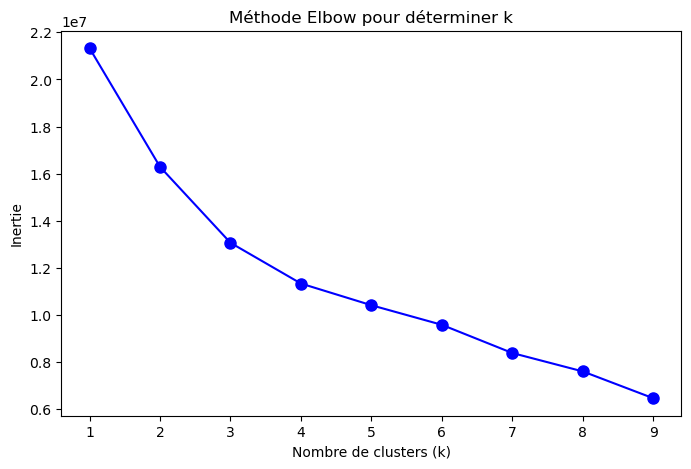

Aperçu des clusters :
  code_departement  cluster
0                0        0
1                0        0
2                0        0
3                0        0
4                0        0


In [71]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Déterminer le nombre optimal de clusters (méthode Elbow)
inertia = []
K = range(1, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(clustering_data_scaled)
    inertia.append(kmeans.inertia_)

# Visualiser la méthode Elbow
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-', markersize=8)
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Inertie')
plt.title('Méthode Elbow pour déterminer k')
plt.show()

# Appliquer K-Means avec un nombre optimal de clusters (par ex. k=3)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(clustering_data_scaled)

# Ajouter les clusters au DataFrame original
df_combined['cluster'] = clusters

print("Aperçu des clusters :")
print(df_combined[['code_departement', 'cluster']].head())


In [72]:
print(clustering_data.describe())


       ratio_dept_france          2018          2019          2020  \
count       3.553893e+06  3.553893e+06  3.553893e+06  3.553893e+06   
mean        1.453851e-02  1.348909e+05 -2.861209e+05  1.039464e+05   
std         7.907319e-03  2.455366e+05  4.024445e+05  1.916624e+05   
min         8.233990e-06 -2.965586e+05 -2.807595e+06 -7.207223e+05   
25%         9.546033e-03  0.000000e+00 -4.498357e+05  4.153126e+03   
50%         1.285818e-02  4.528802e+04 -2.063270e+05  4.715549e+04   
75%         1.773707e-02  1.575274e+05 -3.186760e+04  1.888784e+05   
max         4.217398e-02  1.125085e+06  2.534900e+06  6.955911e+05   

               2021          2022  
count  3.553893e+06  3.553893e+06  
mean   2.525260e+04 -4.190163e+03  
std    9.488475e+04  1.151321e+05  
min   -3.091131e+05 -6.532871e+05  
25%   -5.318756e+03 -2.818228e+04  
50%    1.195463e+04  0.000000e+00  
75%    5.200004e+04  7.198594e+03  
max    6.715598e+05  5.609761e+05  


In [ ]:
£